Librerias

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Hallazgos:

- En la columna "hour" hay la misma cantidad de filas para cada hora, es como si estuviera balanceada en lo que refiere a la hora
- En la columna "weekday" hay una cantidad de filas muy similar para cada dia, esta casi balanceado
- En la columna "month" hay una cantidad de filas muy similar para cada mes, esta casi balanceado
- Los viernes tienen un uso mayor a los demás días de semana entre las 10am y las 4pm, y al mismo tiempo cae la demanda hacia las 5pm, por debajo de los demás días en semana
- Sábados y domingos son los días de menor afluencia
- Sábados y domingos tienen mayor demanda a los días de semana entre 10am y las 4pm
- Entre mayo y octubre se presenta el mayor uso de las bicicletas con apróx 325.000 bicicletas por mes

Df con Query SQL

In [2]:
import sys
sys.path.append('../src')

from database import read_data_sql

query = """
SELECT *
FROM bike_sharing
ORDER BY date_time
"""
df = read_data_sql(query)

df.head(2)

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
1,2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     17544 non-null  float64
 1   workingday  17544 non-null  float64
 2   weather     17544 non-null  object 
 3   temp        17544 non-null  float64
 4   atemp       17544 non-null  float64
 5   hum         17544 non-null  float64
 6   windspeed   17544 non-null  float64
 7   users       17544 non-null  float64
 8   month       17544 non-null  int64  
 9   hour        17544 non-null  int64  
 10  weekday     17544 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 1.6+ MB


Cambio de indice por nombre de dia en columna "weekday"

In [3]:
weekday_map = {
    6: "Sunday",
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday"
}

df["weekday"] = df["weekday"].map(weekday_map)

In [22]:
df["weekday"].value_counts().sort_index(ascending=True)

weekday
Friday       2520
Monday       2496
Saturday     2520
Sunday       2496
Thursday     2520
Tuesday      2496
Wednesday    2496
Name: count, dtype: int64

Grafico Uso Bicicletas por Hora

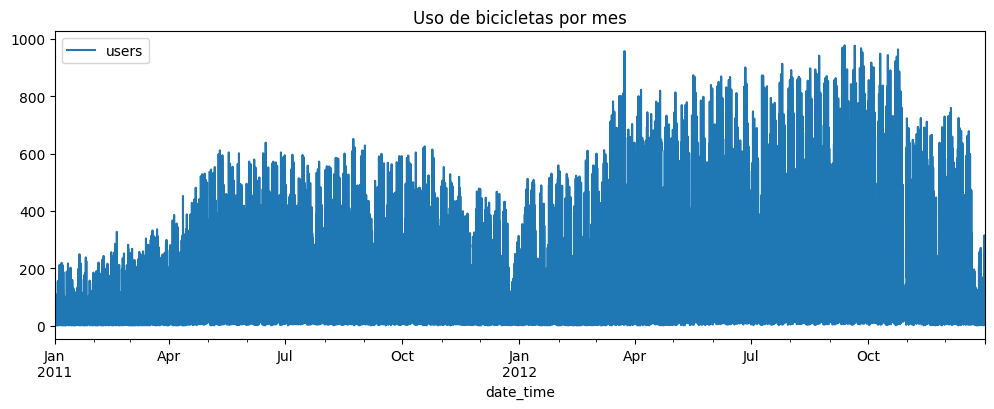

In [7]:
# 1. Parseo de fechas
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.set_index("date_time").sort_index()

df[["users"]].plot(figsize=(12, 4))
plt.title("Uso de bicicletas por mes") #En realidad están los datos de cada hora pero gráficamente se etiqueta mensual
plt.show()

Grafico Resampleo de Datos Diario

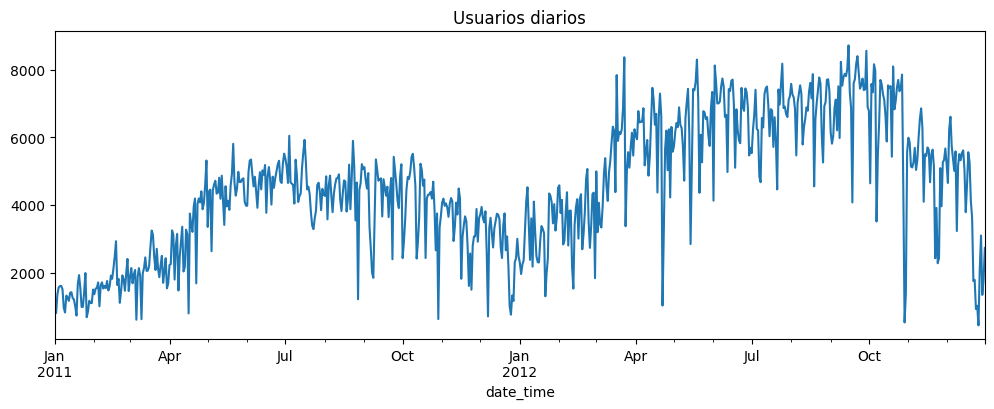

In [3]:
df_daily = df["users"].resample("D").sum()
df_daily.plot(figsize=(12,4))
plt.title("Usuarios diarios")
plt.show()

Graficos de barras ("unique")

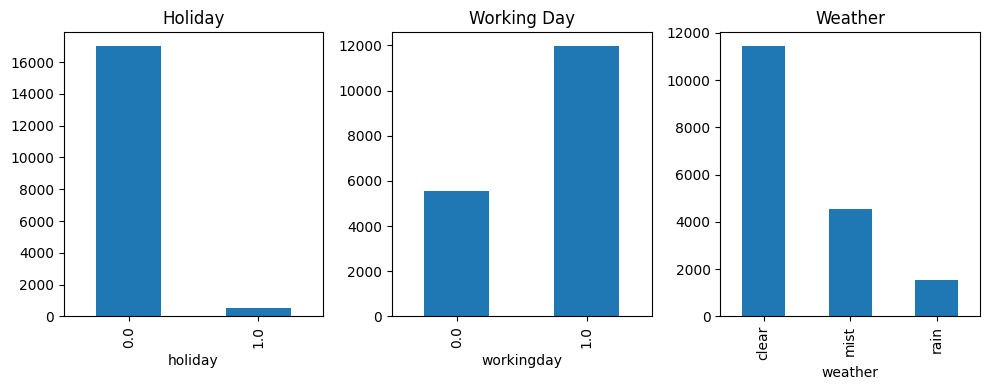

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

plots = [
    lambda ax: df["holiday"].value_counts().sort_index().plot(kind="bar", ax=ax, title="Holiday"),
    lambda ax: df["workingday"].value_counts().sort_index().plot(kind="bar", ax=ax, title="Working Day"),
    lambda ax: df["weather"].value_counts().sort_index().plot(kind="bar", ax=ax, title="Weather"),
    # lambda ax: df["month"].value_counts().sort_index().plot(kind="bar", ax=ax, title="Month"),
    # lambda ax: df["hour"].value_counts().sort_index().plot(kind="bar", ax=ax, title="Hour"),
    # lambda ax: df["weekday"].value_counts().sort_index().plot(kind="bar", ax=ax, title="Weekday"),
    ]

for ax, plot_fn in zip(axes, plots):
    plot_fn(ax)

# Ocultar ejes vacíos
for ax in axes[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

Graficos de histograma ("frecuencia")

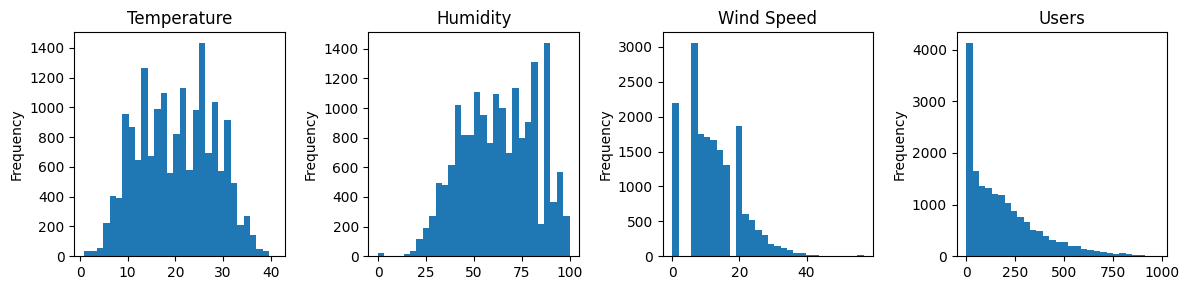

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.flatten()

plots = [
    lambda ax: df["temp"].plot(kind="hist", bins=30, ax=ax, title="Temperature"),
    lambda ax: df["hum"].plot(kind="hist", bins=30, ax=ax, title="Humidity"),
    lambda ax: df["windspeed"].plot(kind="hist", bins=30, ax=ax, title="Wind Speed"),
    lambda ax: df["users"].plot(kind="hist", bins=30, ax=ax, title="Users"),
]

for ax, plot_fn in zip(axes, plots):
    plot_fn(ax)

# Ocultar ejes vacíos
for ax in axes[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

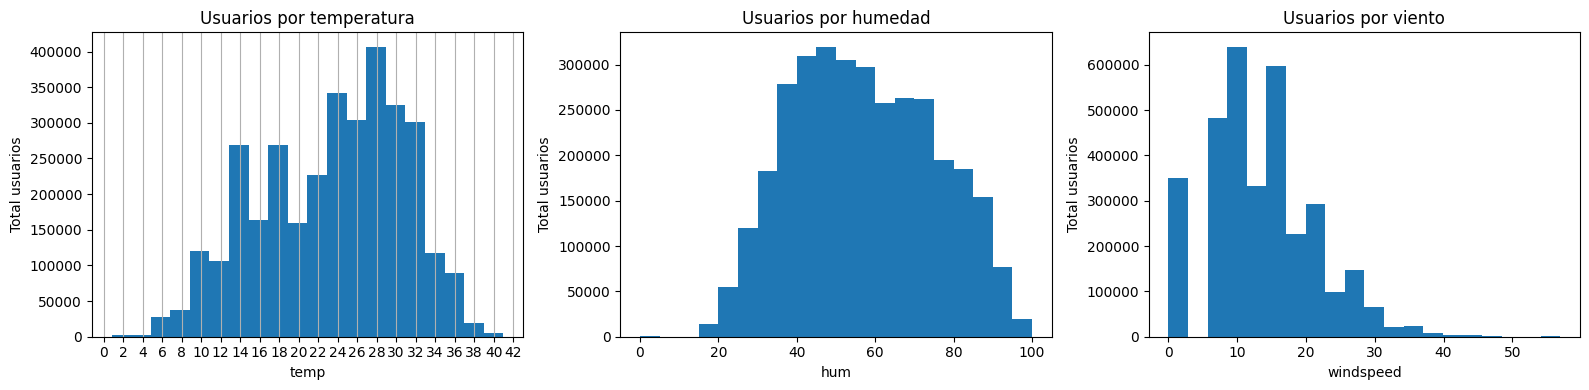

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.flatten()

axes[0].hist(df["temp"], bins=20, weights=df["users"])
axes[0].set_title("Usuarios por temperatura")
axes[0].set_xlabel("temp")
axes[0].set_xticks(range(0, 44, 2))
axes[0].set_ylabel("Total usuarios")
axes[0].grid(axis="x")

axes[1].hist(df["hum"], bins=20, weights=df["users"])
axes[1].set_title("Usuarios por humedad")
axes[1].set_xlabel("hum")
axes[1].set_ylabel("Total usuarios")

axes[2].hist(df["windspeed"], bins=20, weights=df["users"])
axes[2].set_title("Usuarios por viento")
axes[2].set_xlabel("windspeed")
axes[2].set_ylabel("Total usuarios")


plt.tight_layout()
plt.show()


In [ ]:
df.loc[(df["temp"] >= 25) & (df["temp"] < 26), "users"].sum()

np.float64(148189.0)

In [63]:
df["users"].sum()

np.float64(3294677.0)

In [59]:
df.head(1)

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,Saturday


Total de usuarios por dia y hora

weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
hour                                                                   
0        5453.0  3571.0    9902.0  9791.0    4071.0   2818.0     3594.0 



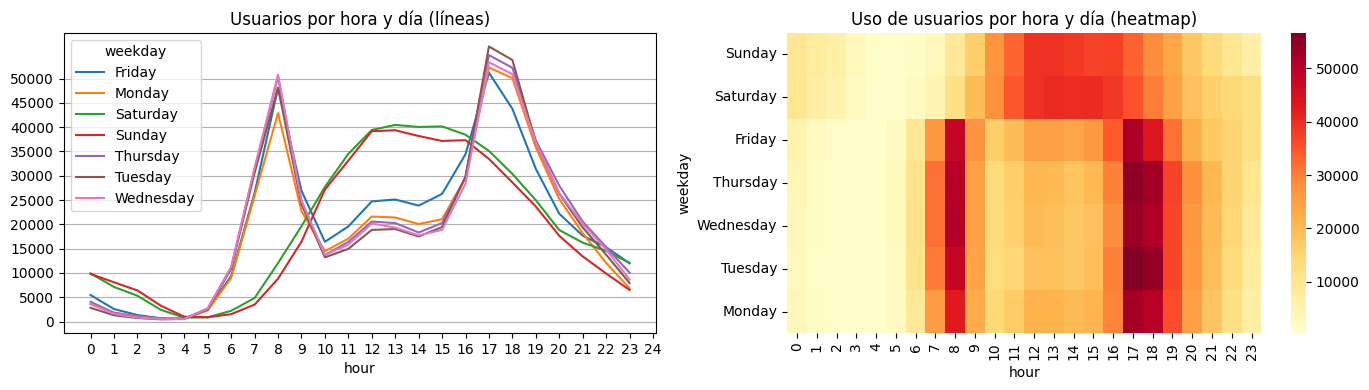

In [45]:
print(pd.pivot_table(df, values="users", index="hour", columns="weekday", aggfunc="sum").head(1),"\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# --- Gráfico 1: líneas ---
pivot_lines = pd.pivot_table(
    df, values="users", index="hour", columns="weekday", aggfunc="sum"
)

pivot_lines.plot(ax=axes[0])
axes[0].set_xticks(range(0, 25, 1))
axes[0].set_yticks(range(0, 55000, 5000))
axes[0].grid(axis="y")
axes[0].set_title("Usuarios por hora y día (líneas)")

# --- Gráfico 2: heatmap ---
pivot_heatmap = pd.pivot_table(
    df, values="users", index="weekday", columns="hour", aggfunc="sum"
)

ordered_days = [
    "Sunday", "Saturday", "Friday",
    "Thursday", "Wednesday", "Tuesday", "Monday"
]

pivot_heatmap = pivot_heatmap.reindex(ordered_days)

sns.heatmap(pivot_heatmap, cmap="YlOrRd", ax=axes[1])
axes[1].set_title("Uso de usuarios por hora y día (heatmap)")

plt.tight_layout()
plt.show()


Grafico Usuarios por Mes

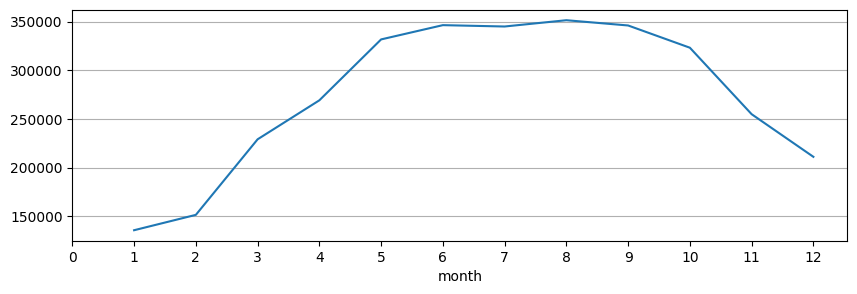

In [25]:
ax = df.groupby("month")["users"].sum().sort_index(ascending=True).plot(figsize=(10, 3))
ax.set_xticks(range(0, 13, 1))
ax.grid(axis="y")
plt.show()